# Fine tuning classification example

We will fine-tune an ada classifier to distinguish between the two mail categories: bullshit and not bullshit.

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [14]:
!pip install --upgrade openai

In [11]:
!openai tools fine_tunes.prepare_data -f mails.jsonl -q

Analyzing...

- Your file contains 20 prompt-completion pairs. In general, we recommend having at least a few hundred examples. We've found that performance tends to linearly increase for every doubling of the number of examples
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace charact

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. 

In [ ]:
%%script bash
export OPENAI_API_KEY=''
openai api fine_tunes.create -t "mails_prepared_train.jsonl" -v "mails_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " bullshit" -m ada

Upload progress: 100%|██████████| 8.07k/8.07k [00:00<00:00, 18.1Mit/s]


Uploaded file from mails_prepared_train.jsonl: file-h2x9knSxH234alsCE8P8UVf4


Upload progress: 100%|██████████| 3.59k/3.59k [00:00<00:00, 2.79Mit/s]


Uploaded file from mails_prepared_valid.jsonl: file-BA8WWpbAor4OazE2rKcBu0n7
Created fine-tune: ft-lWsdn5N8AzluzCLH8CA6l0AU
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-01-11 14:59:29] Created fine-tune: ft-lWsdn5N8AzluzCLH8CA6l0AU
[2023-01-11 15:00:48] Fine-tune costs $0.00
[2023-01-11 15:00:48] Fine-tune enqueued. Queue number: 0
[2023-01-11 15:00:54] Fine-tune started
[2023-01-11 15:01:10] Completed epoch 1/4
[2023-01-11 15:01:14] Completed epoch 2/4
[2023-01-11 15:01:17] Completed epoch 3/4
[2023-01-11 15:01:20] Completed epoch 4/4


The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [25]:
%%script bash
export OPENAI_API_KEY=''
openai api fine_tunes.results -i ft-lWsdn5N8AzluzCLH8CA6l0AU > result.csv

In [26]:
import pandas as pd
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
64,65,11065,65,0.0357,1.0,1.0,0.036846,0.0,0.5,0.5,0.5,1.0,0.0,0.291667,0.666667


The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run. 

<AxesSubplot: >

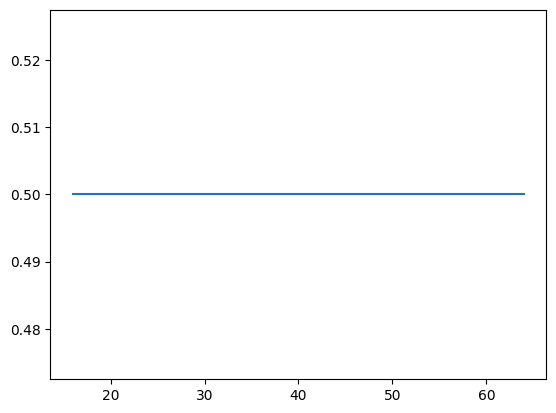

In [23]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## Using the model
We can now call the model to get the predictions.

In [14]:
import pandas as pd
test = pd.read_json('mails_prepared_train.jsonl', lines=True)
test.head()

,prompt,completion
0,"Bonjour à tous,\n\nL’équipe Wood création vous...",bullshit
1,"Bonjour,\n\nNous vous confirmons votre rendez-...",bullshit
2,"Bonjour,\n\nVous venez de recevoir un message ...",bullshit
3,DOKI THONON Thibaut <thibaut.thonon@foncia.com...,bullshit
4,Faites le zoom sur votre conso d'électricité\n...,bullshit


We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [19]:
import openai

openai.api_key = ''
ft_model = 'ada:ft-personal-2023-01-11-14-01-45'
print(test['prompt'][15])
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']


Vous avez envoyé un paiement de €1,00 EUR à Uber Payments BV.

  Afficher ou gérer le paiement
  Cette transaction peut n'apparaître qu'au bout de quelques minutes sur votre compte.

###




' bullshit'

To get the log probabilities, we can specify logprobs parameter on the completion request

In [8]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7f5d8bf80630> JSON: {
  " bullshit": -0.31279054,
  " not": -2.6964135
}

We can see that the model predicts hockey as a lot more likely than baseball, which is the correct prediction. By requesting log_probs, we can see the prediction (log) probability for each class.